# Proyecto Random Forests

In [108]:
# Librería para la declaración y uso de Data Frames:
import pandas as pd

# Librería para generar un modelo de Regresión Lineal: 
import statsmodels.api as sm

# Librería para realizar operaciones matemáticas: 
import numpy as np

# Librería para poder realizar la partición del conjunto de datos:
from sklearn.model_selection import train_test_split

# Librería para generar un modelo XGBoost:
import xgboost as xgb

# Librería para calcular el VIF: 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Librería para visualizar datos estadísticos: 
import seaborn as sns

# Librería para utilizar árboles de decisión clasificadores:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Librería para evaluar el rendimiento de los modelos de Machine Learning:
from sklearn.metrics import *

# Librería para medir la especificidad:
from imblearn.metrics import specificity_score

# Librería para utilizar bosques aleatorios clasificadores:
from sklearn.ensemble import RandomForestClassifier

# Librería para utilizar modelos de optimización de hiperparámetros:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Librería para poder obtener valores aleatorios enteros:
from scipy.stats import randint

## Paso 1 - Lectura de Datos:

En primer lugar, es necesario **leer y guardar la información** en una variable para poder empezar a trabajar con ella.

Para ello, se ha guaradado el archivo con todos los datos en la ruta: */workspaces/random-forests-clara-ab/data/raw/diabetes.csv* y se ha cargado en un Data Frame:

In [109]:
# Lectura del CSV con los datos, dada la ruta donde se guarda el archivo:
df = pd.read_csv ('/workspaces/random-forests-clara-ab/data/raw/diabetes.csv');

# Configuración de pandas para mostrar todas las columnas del DataFrame sin truncarlas al visualizarlo
pd.set_option('display.max_columns', None);

# Se muestran las 5 primeras filas del Data Frame
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Una vez se ha cargado correctamente la información en el Data Frame es interesante evaluar la **cantidad de información que se tiene**. Para ello, se recurre al atributo `.shape` del Data Frame:

In [110]:
# Se utiliza el atributo shape del Data Frame para conocer cuánta información está cargada:
print (f" El conjunto de datos cuenta con información de {df.shape[0]} pacientes con total de {df.shape[1]} características sobre ellos");

 El conjunto de datos cuenta con información de 768 pacientes con total de 9 características sobre ellos


## Paso 2 - Análisis Exploratorio de Datos:

Antes de realizar un estudio del modelo tipo **Decision Trees** , es fundamental llevar a acabo un análisis de los datos **para poder identificar** patrones, detectar valores atípicos y evaluar la distribución de las variables para comprender la relación entre ellas.

Por este motivo, se van a realizar distintos pasos cuyo objetivo final es **preparar el conjunto de datos** para poder trabajar con ellos. Este EDA no se explicará tan en detalle como se hizo para el proyecto dedicado únicamente a ello pero se recomienda recurrir a él para explicaciones más detalladas:

### Paso 2.1 - Análisis de Constantes y Duplicados:

Uno de los puntos críticos a la hora de realizar un análisis, es la existencia de **variables / características comunes** a todos los pacientes, dado que sería **información redundante** y no aportaría valor al estudio, es decir, el análisis sería el mismo aunque no estuviesen como variables y, por lo tanto, se podría prescindir de ellas.

In [111]:
# Se utiliza el método .nunique() para saber la cantidad de columnas con constantes en el Data Frame:
print(f" Hay un total de {(lambda df: (df.nunique() == 1).sum())(df)} columnas en el Data Frame con un valor constante para todos los pacientes");

# Se imprime el conteo de valores distintos en cada columna:
print (f" \nPara cada columna del Data Frame, se muestran cuántos valores distintos presentan:");
df.nunique()

 Hay un total de 0 columnas en el Data Frame con un valor constante para todos los pacientes
 
Para cada columna del Data Frame, se muestran cuántos valores distintos presentan:


Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

A partir del resultado obtenido, se puede observar que **no hay ninguna constante** en los datos cargados, por lo tanto, no hay que eliminar ninguna columna, de momento.

Otro factor determinante a la hora de realizar una limpieza de los datos es detectar si hay **datos repetidos**, aplicado a este caso, si hay **pacientes duplicados**.

In [112]:
# Se utiliza el método .duplicated() para identificar los clientes repetidos dentro del DataFrame:
print(f" Hay un total de {df.duplicated().sum()} pacientes duplicados.");

 Hay un total de 0 pacientes duplicados.


Como se puede ver, **no se ha detectado un cliente duplicado** en el conjunto de datos por lo que se puede seguir con el análisis exploratorio de datos. 

## Paso 2.2 - Análisis Estadístico:

Una vez ya se ha realizado un estudio básico para realizar una primera limpieza de datos, a partir del análisis de constantes y duplicados, se puede pasar a **observar estadísticamente la información** y decidir qué datos son poco relevantes.

Para ello, en primer lugar, se va a recurrir al método `.describe()`  para tener un **resumen estadístico** de todos los datos, tanto los categóricos como los numéricos.

En este resumen, los puntos más interesantes son, por un lado, los **mínimos y los máximos** en las variables numéricas y el **top value y su frecuencia** para las variables categóricas.

In [113]:
# Descripción estadística básica de todas las columnas del DataFrame:
df.describe(include='all').T # Se traspone para ver de forma más clara los datos

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


En este caso, interesa principalmente **desechar pacientes cuya información aportada no fuese** *lógica*. Teniendo en cuenta el conjunto de datos, se puede ver como la mayoría de los **parámetros biométricos tienen su mínimo en 0**, algo imposible para estos parámetros. Por este motivo, lo primero que se ha de realizar es e**liminar los pacientes que presenten estos datos** en tanto que se trata de datos erróneos. 

In [114]:
# El Data Frame se filtra guardando solo las filas mayores de 0 en las columnas de parámetros biométricos:
df_clean = df[(df['Glucose'] > 0) & 
        (df['BloodPressure'] > 0) &
        (df['SkinThickness'] > 0) &
        (df['Insulin'] > 0) &
        (df['BMI'] > 0)];

Por otro lado, simplemente cabe destacar el máximo en la variable *número de embarazos* que es un total de **17**. De momento no se va a desechar en tanto que, pese a ser un dato muy elevado, es posible. 

### Paso 2.3 - Análisis de Nulos: 

Uno de los problemas que es habitual encontrarse en el análisis de datos es **variables sin valor**, nulos.

Es por ello que se deben tratar estos casos para o bien **eliminarlos** o bien **rellenarlos con un valor coherente** para cada uno.

En primer lugar, para realizar el análisis, se va a obtener el **porcentaje de pacientes que presentan al menos un nulo** en alguna de las características.

In [115]:
# Se comprueba el porcentaje de clientes que presentan al menos un valor nulo:
print(f" El {round(df_clean.isnull().any(axis=1).mean()*100, 2)} % de los pacientes presenta, al menos, un valor nulo en alguna de sus características descriptivas");

 El 0.0 % de los pacientes presenta, al menos, un valor nulo en alguna de sus características descriptivas


Se comprueba que **no hay ningún valor faltante en nuestro conjunto de datos**, por lo que no se tiene por qué inferir información en ningún caso.

### Paso 2.4 - Análisis de Observaciones Influyentes:

En este paso se va a proceder a realizar uno de los puntos clave en el Análisis Exploratorio de Datos, la Identificación de **Observaciones Influyentes**.

Sin embargo, para poder realizar este paso, es necesario que todas las variables con las que se trabaja sean numéricas. Por este motivo, en primer lugar, se va a comprobar si hay alguna variable catégorica utilizando el método `.describe()` con el parámetro `include = 'object'`:

In [116]:
# Se comprueba que si hay columnas categóricas:
try:
    # Se intenta obtener el resumen de las columnas categóricas
    print(df_clean.describe(include='object')).T;

except Exception:
    # Si hay un error, es porque no hay columnas categóricas:
    print("No hay variables categóricas en el conjunto de datos.");

No hay variables categóricas en el conjunto de datos.


Una vez ya se comprueba que todas las características numéricas, se puede proceder a **identificar las observaciones influyentes**.

Para ello, en primer lugar es necesario identificar cuál será, de ahora en adelante la **variable dependiente**, es decir, la variable a *predecir* y separar tanto esta como todas las relacionadas con ella.

En este caso, la variable a predecir será `Outcome` , siendo una variable de clase (0 o 1):
-  0 negativo en diabetes
- 1 positivo en diabetes

Teniendo en cuenta que en el conjunto de datos **no hay ninguna otra características relacionada directamente con esta**, las variables independientes serán todo el resto.

In [117]:
# Se separa la variable dependiente: 
#y = df_clean ['Outcome'];

# Se guardan las variables independientes en una matrix, eliminando las características relacionadas con la dependiente:
#X = df_clean.drop(['Outcome'], axis = 1);

Ahora que se tienen los datos separados, se puede proceder a la identificación de observaciones influyentes a partir del estudio de la **Distancia de Cook**.

Este parámetro ayuda a evaluar la **influencia de una observación mediante los coeficientes de un modelo de regresión lineal**. Si la Distancia de Cook de una observación es alta, significa que dicho dato puede estar alterando de forma muy notable el ajuste del modelo.

In [118]:
# Se incluye el término de ordenada en el origen: 
#X = sm.add_constant (X);

# Se ajusta el modelo de Regresión Lineal Ordinaria: 
#model_OLS = sm.OLS(y, X).fit();

# Se hace un diagnóstico de influencia y se extrae la Distancia de Cook: 
#cooks_distance = model_OLS.get_influence().cooks_distance;

Hay una norma estándar que establece un **punto de corte para la Distancia de Cook**, a partir de la cual está aceptado que la información dentro de un conjunto de datos presente. Dicho límite es la **cuarta parte de la longitud total del DataFrame**:

In [119]:
# Se define el Punto de Corte:
#cut_point = 4/len(df);

# Se comprueba cuántas viviendas están por encima de ese punto de corte:
#print(f" Hay un total de {len(np.where(cooks_distance[0]>cut_point)[0])} clientes que se encuentran por encima del punto de corte");

# Se eliminan las observaciones influyentes:
#df_clean = df.drop(np.where(cooks_distance[0] > cut_point)[0]);

### Paso 2.5 - Análisis de Características Relevantes:

Continuando con el proceso de preparación y compresión del conjunto de datos que implica un Análisis Exploratorio, se va a realizar una **Selección de Características**.

Para ello, se va a utilizar un modelo de regresión basado en **XGBoost**, un algoritmo basado en árboles de decisión que utiliza boosting para mejorar la precisión. Por este motivo, el primer paso ha de ser separar el conjunto de datos teniendo una partición para entrenar al modelo (*train*) y otro para probarlo (*test*), de forma que se pueda evaluar sin inferir en el modelo su capacidad predictiva.

In [120]:
# Se separa la variable dependiente: 
y = df_clean ['Outcome'];

# Se guardan las variables independientes en una matrix, eliminando las características relacionadas con la dependiente:
X = df_clean.drop(['Outcome'], axis = 1);

# Se realiza la partición, explicitando el tamaño del test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42);

# Se crea un modelo de regresión XGBoost y se entrena con los datos del 'train_set':
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', random_state = 42).fit(X_train, y_train);

Una vez se tiene el modelo entrenado, se va a generar un DataFrame que contenga el **nombre cada característica y su importancia** en valor porcentual:

In [121]:
# Se extrae la importancia de cada característica en porcentaje y se guarda en un Data Frame:
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100});

# Se ordena el Data Frame en orden de mayor a menor importancia:
df_imp = df_imp.sort_values(by='Importance', ascending=False);

# Se muestra el Data Frame de las características y su importancia: 
df_imp

,Feature,Importance
1,Glucose,30.438169
5,BMI,13.794379
7,Age,12.609548
4,Insulin,11.230547
0,Pregnancies,10.167846
3,SkinThickness,9.141461
2,BloodPressure,6.483466
6,DiabetesPedigreeFunction,6.134581


Como se puede ver, la **característica más importante** que determina la predicción sobre la **concentración de glucosa** en sangre. Sin embargo, **todas las variables parecen tener una relevancia significativa**, siendo la que menos un 5%. 

Por este motivo, se decide **NO desechar ninguna característica** y pasar al análisis de otros parámetros. 

### Paso 2.6 - Análisis del VIF:

Para continuar con el Análisis Exploratorio de los Datos, se va proceder a utilizar una métrica para **detectar la colinealidad entre las variables independientes**, el factor de Inflación de Varianza (**VIF**), pudiendo así saber si una variable puede predecirse de manera lineal usando otras variables y **evitar redundancias** en el conjunto de datos.

In [122]:
# Se calcula el VIF utilizando la función variance_inflation_factor de cada una de las características del conjunto de datos:
vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns);
vif

Pregnancies                  8.047020
Glucose                      5.042648
BloodPressure                2.702926
SkinThickness                7.909090
Insulin                      4.439724
BMI                         10.307008
DiabetesPedigreeFunction     1.243539
Age                         10.810472
dtype: float64

La forma correcta de interpretar un VIF es la siguiente:

- **VIF** = 1 : No hay colinealidad 

- 1 < **VIF** < 5 : Colinealidad Moderada 

- **VIF** > 5 : Colinealidad Alta

Dados los resultados y los criterios de evaluación, se puede comprobar que hay **bastante colinealidad entre las variables**, teniendo **VIFs altos** en **características** que se han obtenido como **relevantes**. Por este motivo, en lugar de eliminar las columnas del Data Frame como mayor VIF, se va a tratar de **combinar aquellas que estén correlacionadas**. 

Para ello, se va a obtener el **mapa de color de la matrix de correlación**, donde se van a poder estudiar estas relaciones entre variables:

<Axes: >

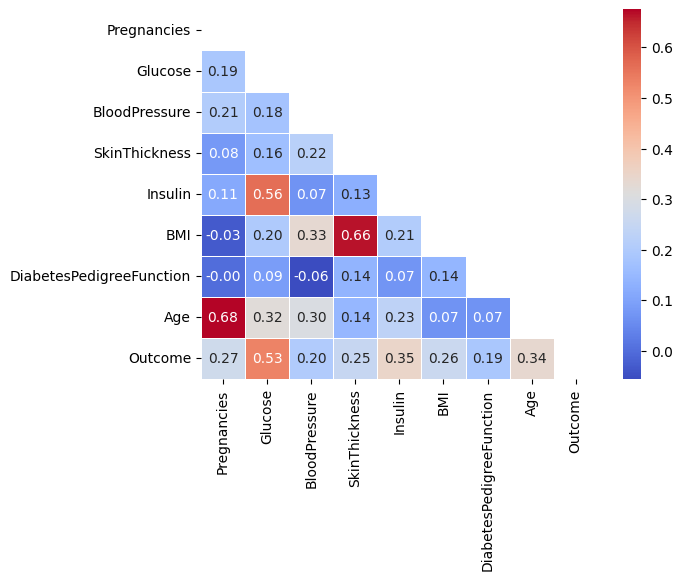

In [123]:
# Se hace una copia del train set:
X_corr = X_train.copy();

# Se añade la columna de precios:
X_corr['Outcome'] = y_train;

# Se calcula la matrix de correlación entre todas las columnas:
corr = X_corr.corr();

# Se crea el mapa de color:
mask = np.triu(np.ones_like(corr, dtype=bool));
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

Gracias a la matrix de correlación se puede ver que la **edad y el número de embarazos** del paciente presentan una **relación bastante alta**; lo mismo pasa con el **BMI y el Skin Thickness**.

Teniendo en cuenta que estas características son algunas de las **más importantes**, no conviene eliminarlas. Sin embargo, se va a generar un *Interaction Term* de forma que se van a **combinar ambos pares de variables** para poder **sumar sus importancias**. En este caso, se ha optado por **multiplicarlas**:

In [124]:
# # # Interaction Term - Age & Pregnancies # # #
X_train['Age_Pregnancies'] = X_train['Age'] * X_train['Pregnancies'];
X_test['Age_Pregnancies'] = X_test['Age'] * X_test['Pregnancies'];

# # # Interaction Term - Skin Thickness & BMI # # #
X_train['Skin_BMI'] = X_train['SkinThickness'] * X_train['BMI'];
X_test['Skin_BMI'] = X_test['SkinThickness'] * X_test['BMI'];

# Se eliminan las características que se han combinado:
X_train.drop(['Age', 'Pregnancies', 'SkinThickness', 'BMI'], axis = 1, inplace = True);
X_test.drop (['Age', 'Pregnancies', 'SkinThickness', 'BMI'], axis = 1, inplace = True);

# Se comprueban los nuevos valores del VIF:
vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

Glucose                     4.501177
BloodPressure               2.003988
Insulin                     3.945085
DiabetesPedigreeFunction    1.237615
Age_Pregnancies             1.511091
Skin_BMI                    1.861456
dtype: float64

Como se puede comprobar, los **valores del VIF han bajado considerablemente**, por lo que se puede proceder con el estudio.

## Paso 3 - Escalado de Variables:

En esta ocasión, al ir a analizar un algoritmo basado en Decision Trees, **no es necesario realizar ningún escalado** al no ser sensibles a estas variaciones.

## Paso 4 - Estudio del modelo de tipo Decision Tree:

Una vez ya se ha **preparado el conjunto de datos** a través del análisis exploratorio de datos y se ha comprendido su distribución y características, se va a llevar a cabo un **estudio de árboles de decisión**, ajustando distintos **hiperparámetros** para optimizar su rendimiento. 

Los **árboles de decisión** son modelos de aprendizaje supervisado cuya estructura jerárquica permite **tomar decisiones sobre los datos** dividiéndolos en subconjuntos más simples. Esta **división varía dependiendo del tipo de algoritmo** de machine learning que se esté utilizado, regresión o clasificación. En este caso, se ha de **predecir si un paciente es o no diabético** (1 o 0), por lo tanto se utlizará un **árbol de decisión de tipo clasificador**. 

La **principal ventaja** de estos modelos recae en su **fácil interpretación**, a la par que la capacidad de manejar datos **sin necesidad de escalado**. Sin embargo, **si no se regulan** adecuadamente mediante los hiperparámetros, pueden caer un **sobreajuste**. 

Para poder definir estos hiperparámetros de forma correcta, es necesario conocer su utilidad:

- `max_depth` : Controla la profundidad máxima del árbol, es decir, el número de iteraciones que ha de realizar sobre el conjunto de datos

- `criterion` : Define la métrica para evaluar la calidad de las divisiones. En este caso, al tratarse de un clasificador, las divisiones dependerán de la entropía, por lo que aquí se puede elegir qué tipo de estadística se desea para medir este parámetro. 

- `min_samples_split` : Número mínimo de muestras necesarias para dividir un nodo

- `min_samples_leaf` : Número mínimo de muestras que debe contener un nodo hoja

- `max_features`: Número máximo de características consideradas en cada división



Teniendo esto en cuenta, para poder evaluar la importancia de una correcta selección de los hiperparámetros, se van a declarar dos tipos de árboles de decisión:

- **Árbol de Decisión Sencillo:** Se realiza una predicción en base a un **entrenamiento poco exhaustivo**. Esto puede llevar a una **tasa de error alta** tanto en el conjunto de **entrenamiento** como en el de **test**. 

- **Árbol de Decisión Complejo:** Se realiza una predicción en base a un **entrenamiento demasiado exhaustivo**. Esto puede llevar a un **sobreajuste** del modelo, es decir, a un **aprendizaje a medida** para el conjunto de **entrenamiento** (con una tasa de error muy baja) pero poco generalizado, con una **tasa de error alta** para el conjunto de **test**. 

De esta forma, como ya se tiene el conjunto de datos separado en train y test, se puede prodecer a **instanciar y entrenar dos objetos** de la clase `DecisionTreeClassifier` para poder comenzar a modelar:

In [125]:
# # # Decision Tree Simple # # #
simple_tree = DecisionTreeClassifier(max_depth = 3, max_features = X_train.shape[1]//2, min_samples_leaf = 10, random_state = 42).fit(X_train, y_train);

# # # Decision Tree Complejo # # #
complex_tree = DecisionTreeClassifier(max_depth = 100, min_samples_leaf = 1, random_state = 42).fit(X_train, y_train);

La elección de hiperparámetros para cada uno de los casos ha sido la siguiente:

- **Árbol de Decisión Simple:** Se ha optado por una **profundidad muy baja**, de solo 3 nodos y un número mínimo de muestras por nodo hoja de 10. Sin embargo, la elección que más puede llegar a influir en la capacidad predictiva del modelo es `max_features` al haber decidido que únicamente se tengan en cuenta la **mitad de las características en cada decisión**. 

Por el contrario...

- **Árbol de Decisión Complejo:** Se ha optado por tener en cuenta **todas las características en cada decisión**, siendo este el valor por defecto y no teniendo que especificarlo. Además, se ha elegido una **profundidad de árbol mucho mayor** y, un número **mínimo de muestras por nodo hoja de 1**. Esto implica que el modelo puede ser demasiado complejo, con muchas hojas individuales que reflejen **variaciones específicas del conjunto de entrenamiento** y no sean generalizables a otros datos. 

A continuación, se va a realizar la **predicción** tanto en los valores de entrenamiento como en los de test, utilizando el método `.predict()`:

In [126]:
# # # Predicción - Decision Tree Simple # # #
y_hat_train_simple_tree = simple_tree.predict(X_train);
y_hat_test_simple_tree = simple_tree.predict(X_test);

# # # Predicción - Decision Tree Complejo # # #
y_hat_train_complex_tree = complex_tree.predict(X_train);
y_hat_test_complex_tree = complex_tree.predict(X_test);

Finalmente, lo interesante es **analizar las métricas** que aportan cada uno de estos modelos para **evaluar su capacidad predictiva**. Para ello, se va a declarar una función, dados las variables objetivo reales y las predichas (para el *train* y *test* set), pueda obtener cada uno de estos parámetros y los muestre por pantalla:

In [127]:
# Definición de la función para obtener las métricas de los modelos dadas las variables objetivo reales y las predichas
def get_metrics(y_train, y_test, y_hat_train, y_hat_test):

    # Se calculan métricas para el TRAIN SET:
    train_accuracy = accuracy_score(y_train, y_hat_train)
    train_f1 = f1_score(y_train, y_hat_train)
    train_auc = roc_auc_score(y_train, y_hat_train)
    train_precision = precision_score(y_train, y_hat_train)
    train_recall = recall_score(y_train, y_hat_train)
    train_specificity = specificity_score(y_train, y_hat_train)

    # Se calculan métricas para el TEST SET:
    test_accuracy = accuracy_score(y_test, y_hat_test)
    test_f1 = f1_score(y_test, y_hat_test)
    test_auc = roc_auc_score(y_test, y_hat_test)
    test_precision = precision_score(y_test, y_hat_test)
    test_recall = recall_score(y_test, y_hat_test)
    test_specificity = specificity_score(y_test, y_hat_test)

    # Se calculan la diferencia entre métricas de entrenamiento y prueba:
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Se crea un DataFrame con los resultados:
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

Los parámetros a calcular son los siguientes:

**- Exactitud (Accuracy):** Proporción de predicciones correctas realizadas. En este caso hace referencia al porcentaje de diabéticos que han sido detectados como tal y al porcentaje de NO diabéticos que han sido identificados como tal. *¿De todas las predicciones realizadas, cuántas acertó el modelo?*

**- F1-Score:** Métrica que combina la Precisión y la Sensibilidad para obtener un valor objetivo en conjuntos de datos que están desbalanceados.
**
**- AUC (Área bajo la curva ROC):** Evalúa la capacidad predictora del clasificador mediendo el área bajo la curva ROC. Un clasificador perfecto tendrá un valor 1.0 y un Random Classifier (dará positivo o negativo de forma aleatoria) tendrá un AUC de 0.5. 

**- Precison (Precisión):** Proporción de predicciones positivas correctas sobre todas las predicciones positivas realizadas. Esta métrica es muy importante cuando es necesario minimizar los falsos positivos. *De todas las veces que el modelo predijo que el paciente era diabético ¿cuántas veces acertó?* 

**- Recall (Sensibilidad):** Proporción de casos positivos correctamente identificados sobre el total de casos positivos reales. Esta métrica es crucial en los casos donde se prioriza detectar todos los casos positivos, minimizar el número de falsos negativos. *De todas las veces que el paciente realmente era diabético ¿cuántas veces lo detectó?*

**- Specificity (Especificidad):** Proporción de casos negativos correctamente identificados sobre el total de casos negativos reales. *De todas las veces que el paciente NO era diabético, ¿cuántas veces el modelo lo detectó?*

Antes de pasar al estudio de las métricas es importante comprobar **cómo de balanceado está el conjunto de datos**, es decir, que el número de diabéticos y no diabéticos es similar.

Para ello, se va a estudiar el **número de 0s y de 1s** que hay en la variable dependiente `Outcome`:

In [128]:
df_clean['Outcome'].value_counts()

Outcome
0    262
1    130
Name: count, dtype: int64

Como se puede comprobar, el conjunto de datos **no está balanceado**, al tener muchos más datos de pacientes NO diabéticos que diabéticos. 

Esto es algo que **afecta a las métricas que analizan la capacidad predictiva** del modelo y se deberán tener en cuenta para el análisis de los resultados. 

Teniendo todo esto en cuenta, se puede proceder a obtener las métricas para los **dos tipos de árbol de decisión** generados:

In [129]:
# # # Métricas - Decision Tree Simple # # #
get_metrics (y_train, y_test, y_hat_train_simple_tree, y_hat_test_simple_tree)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.795527,0.584416,0.704161,0.882353,0.436893,0.971429
Test,0.734177,0.511628,0.655627,0.687500,0.407407,0.903846
Diferencia,0.061350,0.072788,0.048534,0.194853,0.029486,0.067582


Las **diferencias obtenidas** entre los resultados para el conjunto de test y el de train son **mayores al 10%** en la mayoría de los casos, lo que ya es un indicativo de **baja performance** del modelo dados unos hiperparámetros tan poco exhaustivos. 

Debido al **desbalance** visto en el conjunto de datos,  el **F1-Score** es un parámetro que da información fiable para analizar la capacidad predictiva del modelo. En este caso, se ha obtenido un **67.63%** en el conjunto de entrenamiento, **porcentaje bastante bajo**, indicando así que el modelo **pierde rendimiento en la detección de la clase minoritaria**, siendo precisamente la de los pacientes diabéticos. Esto también se puede estudiar en la **Sensibilidad** (Recall) donde **de cada 100 veces que se puede encontrar con un paciente diabético**, realmente solo **acertó 59** para el conjunto de **entrenamiento** y **47** para el de **prueba**, esto es muy bajo. **Lo contrario ocurre en la Especificidad**, en donde se tienen unos porcentajes bastante altos debido a que, al tener un mayor número de pacientes NO diabéticos, es más probable que acierte. 

Una vez ya se ha estudiado el caso del árbol de decisión sencillo, se va a pasar a evaluar los resultados del complejo:

In [130]:
# # # Métricas - Decision Tree Complejo # # #
get_metrics (y_train, y_test, y_hat_train_complex_tree, y_hat_test_complex_tree)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.00000,1.000000,1.0,1.000000,1.000000
Test,0.658228,0.44898,0.597934,0.5,0.407407,0.788462
Diferencia,0.341772,0.55102,0.402066,0.5,0.592593,0.211538


En esta ocasión, lo más destacable es el **gran sobreajuste** al que ha llegado el modelo, teniendo unas **métricas perfectas** para el conjunto de **entrenamiento** pero **bastante malas** para el conjunto de **prueba**.

Este *overfitting* es debido a los hiperparámetros seleccionados, dado que llevan al árbol de decisión a expandirse tanto que **particularizan mucho para el conjunto de datos concreto** con el que entrenan. Al definir una profundidad tan elevada y permitir que haya nodos hoja con una única muestra, lo que se está consiguiendo es llegar a una **clasificación demasiado en detalle** que no es para **nada generalizable** a otros casos. Por este motivo, el **conjunto de prueba tiene un rendimiento tan pobre**. 

Si se evalúan algunos de los parámetros obtenidos en el *test set*, teniendo también en cuenta el **desbalance de datos**, se puede observar que la **Sensibilidad** es **muy baja** al solo llegar al 50%. La **Especificidad**, como cabía esperar, es la **métrica más alta** debido al número mayoritario de pacientes NO diabéticos. 

A continuación se va a pasar a realizar un análisis **variando dos hiperparámetros** de todos los posibles: `max_depth` y `min_samples_leaf`. 

De esta forma, se va a **fijar el valor para uno de ellos**, mientras que **se varíe para el otro** y se van a ir obteniendo las métricas. Con esto se consigue ver **cuál es la influencia de cada parámetro sobre el rendimiento final** y sería algo útil para poder llegar a ajustar el modelo con unos valores de hiperparámetros ideales. 

Para ello, se va a utilizar un bucle `for` que itere sobre los posibles valores que se deseen probar para cada hiperparámetro, se generará el modelo y se llamará a la función `get_metrics()` para obtener las métricas:

### Combinación 1: `min_samples_leaf` fijo, `max_depth` variable:

Para esta primera combinación se van a **variar los valores de la profundidad del árbol**.

Se han probado **distintos rangos** y se ha comprobado que las **métricas no variaban** en ningún decimal para ninguno de los dos conjuntos **hasta llegar a los 10 escalones de profundidad**.

Por este motivo, el **bucle comienza** a dar valores **en 10 y avanza en pasos de 2**. 

In [131]:
# # # COMBINACIÓN 1 - max_depth variable # # #
for depth in range(10, 1, -2): 

    # Se genera y entrena el modelo:
    decision_tree = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = 1, random_state = 42).fit(X_train, y_train);

    # Se obtiene la predicción para el conjunto de train:
    y_hat_train_tree = decision_tree.predict(X_train);

    # Se obtiene la predicción para el conjunto de test:
    y_hat_test_tree = decision_tree.predict(X_test);
    
    # Se obtienen las métricas:
    metrics = get_metrics (y_train, y_test, y_hat_train_tree, y_hat_test_tree);
    
    # Se imprime la profundidad del modelo actual:
    print(f"Resultados para max_depth = {depth}:");

    # Se imprimen las métricas para la profundidad actual:
    print(metrics);
    print("-" * 50)

Resultados para max_depth = 10:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.996805  0.995122  0.995146   1.000000  0.990291     1.000000
Test        0.670886  0.480000  0.616453   0.521739  0.444444     0.788462
Diferencia  0.325919  0.515122  0.378693   0.478261  0.545847     0.211538
--------------------------------------------------
Resultados para max_depth = 8:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.958466  0.938389  0.959154   0.916667  0.961165     0.957143
Test        0.670886  0.458333  0.607550   0.523810  0.407407     0.807692
Diferencia  0.287580  0.480055  0.351604   0.392857  0.553758     0.149451
--------------------------------------------------
Resultados para max_depth = 6:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.910543  0.869159  0.908599   0.837838  0.902913     0.914286
Test        0.670886  0.500000  0.625356   0.520000  0

Para una profundidad de 10 nodos, el sobreajuste se ha visto disminuido pero se sigue teniendo muchísima diferencia con respecto al conjunto de prueba. 

Sin embargo, según se reduce `max_depth` se puede comprobar que la disparidad entre ambos sets de datos es cada vez menor llegando a un punto en el que las métricas no son buenas para ninguno de los dos casos. Por esta razón, se debe encontrar un compromiso entre el sobreajuste y un rendimiento aceptable.

En este caso, teniendo en cuenta que estamos usando **mucho detalle en el parámetro fijo** `min_samples_leaf` parece que la **mejor opción para la profundidad** del árbol de decisión es **8 o 6**.

### Combinación 2: `max_depth` fijo, `min_samples_leaf` variable:

Para esta segunda combinación, se va a tener en cuenta el estudio que se acaba de realizar, donde se ha visto que para el `min_samples_leaf` con el que se estaba trabajando, la mejor `max_depth` era 8 o 6.

Considerando que este valor para un número mínimo de muestras en el nodo hoja es muy bajo, se va a apostar por el valor más alto de profundidad y se van a obtener las métricas fijando `max_depth = 8` y variando `min_samples_leaf` de 2 en 2 empezando desde 10:



In [132]:
# # # COMBINACIÓN 2 - min_samples_leaf variable # # #
for leaf in range(10, 1, -2):  # Desde 10 hasta 1

    # Se genera y entrena el modelo:
    decision_tree = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = leaf, random_state = 42).fit(X_train, y_train);

    # Se obtiene la predicción para el conjunto de train:
    y_hat_train_tree = decision_tree.predict(X_train);

    # Se obtiene la predicción para el conjunto de test:
    y_hat_test_tree = decision_tree.predict(X_test);
    
    # Se obtienen las métricas:
    metrics = get_metrics (y_train, y_test, y_hat_train_tree, y_hat_test_tree);
    
    # Se imprime el número minimo de muestras en el nodo hoja del modelo actual:
    print(f"Resultados para min_samples_leaf = {leaf}:");

    # Se imprimen las métricas para el número minimo de muestras en el nodo hoja del modelo actual:
    print(metrics);
    print("-" * 50);

Resultados para min_samples_leaf = 10:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.846645  0.752577  0.811512   0.802198  0.708738     0.914286
Test        0.759494  0.612245  0.710470   0.681818  0.555556     0.865385
Diferencia  0.087152  0.140332  0.101042   0.120380  0.153182     0.048901
--------------------------------------------------
Resultados para min_samples_leaf = 8:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.862620  0.798122  0.853098   0.772727  0.825243     0.880952
Test        0.696203  0.555556  0.662393   0.555556  0.555556     0.769231
Diferencia  0.166417  0.242567  0.190704   0.217172  0.269687     0.111722
--------------------------------------------------
Resultados para min_samples_leaf = 6:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.875399  0.807882  0.855201   0.820000  0.796117     0.914286
Test        0.734177  0.571429  0

Resultados para min_samples_leaf = 2:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.932907  0.893401  0.912899   0.936170  0.854369     0.971429
Test        0.721519  0.476190  0.637108   0.666667  0.370370     0.903846
Diferencia  0.211388  0.417211  0.275790   0.269504  0.483999     0.067582
--------------------------------------------------


En este caso se puede ver que mientras que en el **conjunto de entrenamiento**, a **menor número de muestras por nodo hoja, mejores resultados**, en el **conjunto de prueba** llega un momento en el que **se estabilizan las métricas**. Esto implica que, si `min_samples_leaf` es **menor de 6** lo único que se consigue es **sobreajustar** el modelo e incrementar la diferencia entre ambos sets. 

Por este motivo, se estima que para este conjunto de datos, el **número de muestras mínimo por nodo hoja ha de ser 6**. 

Finalmente, teniendo en cuenta este breve análisis, se puede estimar que la **optimización de hiperparámetros** para el conjunto de datos que se está utilizando es la siguiente:

- `max_depth` : 8

- `min_samples_leaf` : 6

Las métricas que se obtienen no son las ideales, y aun se podría perfeccionar más el modelo pero dado el análisis realizado, es la mejor de las combinaciones:

In [133]:
# # # Decision Tree # # #
decision_tree = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 6, random_state = 42).fit(X_train, y_train);

# # # Predicción - Decision Tree Complejo # # #
y_hat_train_tree = decision_tree.predict(X_train);
y_hat_test_tree = decision_tree.predict(X_test);

# # # Métricas - Decision Tree Complejo # # #
get_metrics (y_train, y_test, y_hat_train_tree, y_hat_test_tree)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.875399,0.807882,0.855201,0.820000,0.796117,0.914286
Test,0.734177,0.571429,0.682336,0.636364,0.518519,0.846154
Diferencia,0.141222,0.236453,0.172865,0.183636,0.277598,0.068132


## Paso 5 - Estudio Random Forests:

Los **bosques aleatorios** (Random Forest) son modelos de aprendizaje supervisado que **combinan múltiples árboles de decisión** para **mejorar la precisión y reducir el sobreajuste**. A diferencia de un solo árbol de decisión, Random Forest construye varios árboles en paralelo utilizando **diferentes subconjuntos de datos y características**, generando de esta forma un modelo más robusto.

En este caso, igual que para `Decision Trees` al tener que predecir **si un paciente es o no diabético** (1 o 0), se utilizará un **Random Forest de clasificación**, que permite combinar múltiples predicciones individuales de los árboles para obtener un **resultado final más preciso** mediante técnicas como el voto mayoritario.

Para poder definir los **hiperparámetros** de forma correcta, es necesario conocer su utilidad:

- `n_estimators` : Número de árboles en el bosque. Un mayor número de árboles suele mejorar el rendimiento, pero aumenta el costo computacional.

- `bootstrap` : Indica si se deben muestrear los datos con reemplazo al construir cada árbol, lo que introduce variabilidad y mejora la generalización.

- `max_depth` : Controla la profundidad máxima de cada árbol individual dentro del bosque, limitando la complejidad del modelo.

- `min_samples_split` : Número mínimo de muestras necesarias para dividir un nodo en cada árbol.

- `min_samples_leaf` : Número mínimo de muestras que debe contener un nodo hoja en cada árbol.

- `max_features` : Número máximo de características consideradas en cada división, lo que introduce aleatoriedad y ayuda a reducir la correlación entre árboles.

Teniendo esto en cuenta, para poder evaluar la importancia de una correcta selección de los hiperparámetros, se van a declarar dos tipos de modelos Random Forest:

**- Random Forest Sencillo:** Se realiza una predicción en base a un entrenamiento poco exhaustivo, utilizando un número reducido de árboles y características. Esto puede llevar a una tasa de error alta tanto en el conjunto de entrenamiento como en el de test, debido a una falta de generalización.

**- Random Forest Complejo:** Se realiza una predicción en base a un entrenamiento demasiado exhaustivo, con un número elevado de árboles y características. Esto puede llevar a un sobreajuste del modelo, es decir, a un aprendizaje a medida para el conjunto de entrenamiento (con una tasa de error muy baja) pero poco generalizado, con una tasa de error alta para el conjunto de test.

De esta forma, como ya se tiene el conjunto de datos separado en train y test, se puede prodecer a **instanciar y entrenar dos objetos** de la clase `RandomForestClassifier` para poder comenzar a modelar:

In [134]:
# # # Random Forest Simple # # #
simple_forest = RandomForestClassifier(n_estimators = 5, random_state = 42, max_depth = 3, min_samples_leaf = 10, max_features = X_train.shape[1]//2).fit(X_train, y_train);

# # # Random Forest Complejo # # #
complex_forest = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = 100, min_samples_leaf=1, max_features = int(X_train.shape[1]*0.8)).fit(X_train, y_train);

La elección de hiperparámetros para cada uno de los casos ha sido la siguiente:

- **Bosque Aleatorio Simple:**  Se ha optado por un **número reducido de árboles en el bosque**, utilizando únicamente 5 estimadores, lo que puede llegar a mermar bastante la capacidad de aprendizaje. En relación al resto de hiperparámetros, se ha decidido **utilizar el mismo número que se empleó para el caso del Árbol de Decisión Simple** para poder así realizar una **comparación**.

Por el contrario...

- **Bosque Aleatorio Complejo:** Se ha optado por un **mayor número de árboles en el bosque**, empleando un total de 100 estimadores lo que podría proporcionar una mayor capacidad de aprendizaje. En cuanto al resto de hiperparámetros, igual que en el caso anterior, se ha decidido **utilizar el mismo número que se empleó para el caso del Árbol de Decisión Complejo** y poder así realizar una comparación. La única diferencia, en este caso, es el **número de características** que se toman en cada decisión para tratar de **reducir la posible correlación** entre los árboles.  

In [135]:
# # # Predicción - Decision Tree Simple # # #
y_hat_train_simple_forest = simple_forest.predict(X_train);
y_hat_test_simple_forest = simple_forest.predict(X_test);

# # # Predicción - Decision Tree Complejo # # #
y_hat_train_complex_forest = complex_forest.predict(X_train);
y_hat_test_complex_forest = complex_forest.predict(X_test);

Finalmente, lo interesante es **analizar las métricas** que aportan cada uno de estos modelos para **evaluar su capacidad predictiva**. Para ello, se va a utilizar la misma función que se empleó en el análisis de Árboles de Decisión donde, dadas las variables objetivo reales y las predichas (para el *train* y *test* set), se pueda obtener cada uno de estos parámetros y los muestre por pantalla.

Teniendo todo esto en cuenta, se puede proceder a obtener las métricas para los **dos tipos de Bosques Aleatorios** generados:

In [136]:
# # # Métricas - Random Forest Simple # # #
get_metrics (y_train, y_test, y_hat_train_simple_forest, y_hat_test_simple_forest)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.811502,0.662857,0.748220,0.805556,0.563107,0.933333
Test,0.721519,0.476190,0.637108,0.666667,0.370370,0.903846
Diferencia,0.089983,0.186667,0.111112,0.138889,0.192736,0.029487


En este caso, al contrario de lo que ocurría para el Árbol de Decisión Simple, las **diferencias obtenidas** entre el conjunto de test y el de train son **menores al 10% **en la mayoría de los casos, lo que podría ser un indicativo de una **ligera mejora de la performance del modelo**, aunque siga siendo **baja** por una elección de hiperparámetros poco exhaustivos. 

Sin embargo, debido al **desbalance del conjunto de datos**, la principal métrica a estudiar para analizar la capacidad predictiva del modelo el **F1-Score**, sí ha **superado el 10% de diferencia** pero ha **mejorado** en un **3.5%** entre el set de entrenamiento y el de prueba. Si se evalúan los resultados obtenidos para este parámetro, se puede observar que el **rendimiento es similar** en ambos modelos, habiendo variado únicamente un 0.75% para el **conjunto de train**, mientras que sí ha habido una **mejora cercana al 3% para el test set**. 

Por otro lado, si se estudia el otro parámetro importante en casos de desbalance, la **Sensibilidad** (Recall), también se han dado **mejoras entre un 2% - 5%** para el train y test set respectivamente. 

Por último, cabe destacar que la Especificidad, especialmente potenciada por la distribución de información en este conjunto de datos ha tenido incrementos significativos, como cabía esperar, sobretodo en el conjunto de prueba, así como en la **Precisión**, donde sí ha habido avances considerables con **incrementos de casi un 10%** en ambos conjuntos de datos. 


Una vez ya estudiados los resultados para el Bosque de Decisión Simple, se puede proceder a analizar el Complejo:

In [137]:
# # # Métricas - Random Forest Complejo # # #
get_metrics (y_train, y_test, y_hat_train_complex_forest, y_hat_test_complex_forest)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000,1.000000,1.000000
Test,0.734177,0.588235,0.691239,0.625,0.555556,0.826923
Diferencia,0.265823,0.411765,0.308761,0.375,0.444444,0.173077


Como ya ocurrió en el caso del Árbol de Decisión Complejo, el modelo ha **sobreajustado** hasta conseguir unas **métricas perfectas para el conjunto de entrenamiento** pero bastante **pobres para el de prueba**. 

Aun así se han obtenido **incrementos significativos** en el *test set*, habiendo **mejorado en casi un 10%** los resultados del **F1-Score** y en un **6**% para la **Sensibilidad**. Sin embargo, como es lógico, las **diferencias entre ambos conjuntos de datos son muy superiores al 10%** al haber generado un **modelo muy detallado** para el conjunto de datos de entrenamiento y **nada generalizable para cualquier otro set**. 

A continuación, tal y como se hizo para los árboles de decisión, se va a pasar a realizar un análisis **variando dos hiperparámetros** de todos los posibles. En este caso, se han escogido `max_depth` y `n_estimators`, definiendo el resto de ellos a conveniencia. 

De esta forma, se va a **fijar el valor para uno de ellos**, mientras que **se varíe para el otro** y se van a ir obteniendo las métricas. Con esto se consigue ver **cuál es la influencia de cada parámetro sobre el rendimiento final** y sería algo útil para poder llegar a ajustar el modelo con unos valores de hiperparámetros ideales. 

Para ello, se va a utilizar un bucle `for` que itere sobre los posibles valores que se deseen probar para cada hiperparámetro, se generará el modelo y se llamará a la función `get_metrics()` para obtener las métricas:

### Combinación 1: `max_depth` fijo, `n_estimators` variable:

Para esta primera combinación se van a **variar el número de árboles en el bosque**.

Se han probado **distintos rangos** y se ha comprobado que el intervalo donde mejores resultados se estaban obteniendo era entre **70 - 35 árboles**. Por **encima de 75** las **diferencias** entre el conjunto de entrenamiento eran **muy elevadas** y, al igual que **por debajo de 35** donde, además, el **rendimiento del modelo era bajo** incluso para el conjunto de entrenamiento.

Por este motivo, el **bucle comienza** a dar valores **en 70 y avanza en pasos de 5 en 5 hasta 35**. 

In [138]:
# # # COMBINACIÓN 1 - n_estimators variable # # #
for n_trees in range(70, 35, -5): 

    # Se genera y entrena el modelo:
    random_forest = RandomForestClassifier(n_estimators = n_trees, random_state = 42, max_depth = 20, min_samples_leaf = 6, max_features = int(X_train.shape[1]*0.8)).fit(X_train, y_train);

    # Se obtiene la predicción para el conjunto de train:
    y_hat_train_forest = random_forest.predict(X_train);

    # Se obtiene la predicción para el conjunto de test:
    y_hat_test_forest = random_forest.predict(X_test);
    
    # Se obtienen las métricas:
    metrics = get_metrics (y_train, y_test, y_hat_train_forest, y_hat_test_forest);
    
    # Se imprime la profundidad del modelo actual:
    print(f"Resultados para n_estimators = {n_trees}:");

    # Se imprimen las métricas para el número de árboles actual:
    print(metrics);
    print("-" * 50)

Resultados para n_estimators = 70:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.891374  0.824742  0.862159   0.879121  0.776699     0.947619
Test        0.746835  0.600000  0.700855   0.652174  0.555556     0.846154
Diferencia  0.144538  0.224742  0.161304   0.226947  0.221143     0.101465
--------------------------------------------------
Resultados para n_estimators = 65:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.884984  0.810526  0.849977   0.885057  0.747573     0.952381
Test        0.746835  0.615385  0.709758   0.640000  0.592593     0.826923
Diferencia  0.138149  0.195142  0.140219   0.245057  0.154980     0.125458
--------------------------------------------------
Resultados para n_estimators = 60:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.891374  0.821053  0.857212   0.896552  0.757282     0.957143
Test        0.721519  0.560000  0.672721   

Como se ha mencionado, tras pobrar distintos intervalos, el rango estudiado es el que obtenía menores diferencias entre el conjunto de entrenamiento y el de prueba. 

Dentro de todos los posibles `n_estimators` el número de árboles que parece más apropiado, es 45 árboles por bosque. 

En este caso, algo que ha podido **influir en el desarrollo del modelo** es que se ha definido el parámetro `min_samples_leaf` con el **valor estudiado** previamente para el análisis de los árboles de decisión. Si este **hiperparémtro hubiese sido menor**, se habría dado un **sobreajuste** mucho más significativo, teniendo resultados como los vistos anteriormente donde todo el conjunto de entrenamiento habría sido predicho a la perfección. 


### Combinación 2: `max_depth` variable, `n_estimators` fijo:

Para esta segunda combinación se van a **variar los valores de la profundidad del árbol**, teniendo fijo el `n_estimators` a 45 árboles tal y como se ha evaluado en la combinación anterior.

Se han probado **distintos rangos** y se ha comprobado que las **métricas no variaban** en ningún decimal para ninguno de los dos conjuntos **hasta llegar a los 12 escalones de profundidad**.

Por este motivo, el **bucle comienza** a dar valores **en 12 y avanza en pasos de 2**. 

In [139]:
# # # COMBINACIÓN 2 - max_depth variable # # #
for depth in range(12, 1, -2): 

    # Se genera y entrena el modelo:
    random_forest = RandomForestClassifier(n_estimators = 45, random_state = 42, max_depth = depth, min_samples_leaf = 6, max_features = int(X_train.shape[1]*0.8)).fit(X_train, y_train);

    # Se obtiene la predicción para el conjunto de train:
    y_hat_train_forest = random_forest.predict(X_train);

    # Se obtiene la predicción para el conjunto de test:
    y_hat_test_forest = random_forest.predict(X_test);
    
    # Se obtienen las métricas:
    metrics = get_metrics (y_train, y_test, y_hat_train_forest, y_hat_test_forest);
    
    # Se imprime la profundidad del modelo actual:
    print(f"Resultados para max_depth = {depth}:");

    # Se imprimen las métricas para la profundidad actual:
    print(metrics);
    print("-" * 50)

Resultados para max_depth = 12:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.888179  0.816754  0.854831   0.886364  0.757282     0.952381
Test        0.734177  0.571429  0.682336   0.636364  0.518519     0.846154
Diferencia  0.154002  0.245325  0.172495   0.250000  0.238763     0.106227
--------------------------------------------------
Resultados para max_depth = 10:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.888179  0.816754  0.854831   0.886364  0.757282     0.952381
Test        0.734177  0.571429  0.682336   0.636364  0.518519     0.846154
Diferencia  0.154002  0.245325  0.172495   0.250000  0.238763     0.106227
--------------------------------------------------
Resultados para max_depth = 8:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.888179  0.814815  0.852358   0.895349  0.747573     0.957143
Test        0.734177  0.571429  0.682336   0.636364  

A medida que se va **reduciendo la profundidad**, el **rendimiento** va también **bajando** y se **aumenta la diferencia** con respecto al conjunto de prueba. 

Por esta razón, se opta por un **detalle medio en la profundidad** y se define como mejor opción para el **hiperparámetro** `max_depth` un total de **12 niveles** en cada árbol estimador del bosque. 

Finalmente, teniendo en cuenta este breve análisis, se puede estimar que la **optimización de hiperparámetros** para el conjunto de datos que se está utilizando es la siguiente:

- `n_estimador` : 45
- `max_depth` : 12

Las métricas que se obtienen no son las ideales, y aun se podría perfeccionar más el modelo pero dado el análisis realizado, es la mejor de las combinaciones:

In [140]:
# # # Random Forest # # #
random_forest = RandomForestClassifier(n_estimators = 45, random_state = 42, max_depth = 12, min_samples_leaf = 6, max_features = int(X_train.shape[1]*0.8)).fit(X_train, y_train);

# Se obtiene la predicción para el conjunto de train:
y_hat_train_forest = random_forest.predict(X_train);

# Se obtiene la predicción para el conjunto de test:
y_hat_test_forest = random_forest.predict(X_test);

# Se obtienen las métricas:
get_metrics (y_train, y_test, y_hat_train_forest, y_hat_test_forest)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.888179,0.816754,0.854831,0.886364,0.757282,0.952381
Test,0.734177,0.571429,0.682336,0.636364,0.518519,0.846154
Diferencia,0.154002,0.245325,0.172495,0.250000,0.238763,0.106227


Finalmente, para tratar de obtener la mejor optimización de hiperparámetros, se van a estudiar dos técnicas:

- GridSearch (Búsqueda por cuadrícula)
- RandomSearch (Búsqueda Aleatoria)

### Optimización 1 - GridSearch:

Esta técnica de **optimización de hiperparámetros** diseña una **malla con las posibles combinaciones** para los posibles valores de cada hiperparámetro. Posteriormente, realiza una **validación cruzada** de forma que se dividen los datos en múltiples particiones y se entrena en ellas y se valida con el resto para poder promediar los resultados obtenidos. 

Para poder utilizarlo, es necesario, por lo tanto, definir el espacio de búsqueda para cada uno de los hiperparámetros que se han tenido en cuenta a lo largo de todo el estudio:

In [141]:
# Se define el modelo de forma general: 
random_forest = RandomForestClassifier(random_state = 42);

# Se define el espacio de búsqueda de hiperparámetros: 
grid_parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
};

# Se configura la búsqueda en malla con la validación cruzada:
grid_search = GridSearchCV(estimator = random_forest, param_grid = grid_parameters, cv = 5, n_jobs = -1, verbose = 1);

# Se ajusta el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train);

# Se muestran los mejores hiperparámetros encontrados los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}");

# Se evalúa el mejor modelo:
best_random_forest = grid_search.best_estimator_;

# Se obtiene la predicción para el conjunto de train:
y_hat_train_forest = best_random_forest.predict(X_train);

# Se obtiene la predicción para el conjunto de test:
y_hat_test_forest = best_random_forest.predict(X_test);

# Se obtienen las métricas:
get_metrics (y_train, y_test, y_hat_train_forest, y_hat_test_forest)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.929712,0.887755,0.908044,0.935484,0.844660,0.971429
Test,0.759494,0.595745,0.701567,0.700000,0.518519,0.884615
Diferencia,0.170219,0.292010,0.206477,0.235484,0.326142,0.086813


Si se estudian las **métricas interesantes para el conjunto de datos desbalanceado**, se puede comprobar que con esta técnica de optimización de parámetros se han conseguido **resultados muy similaress a los obtenidos mediante la evaluación de hiperparámetros de forma manual**. 

Se va a probar **otro espacio de búsqueda** considerando los hiperparámetros encontrados como óptimos de forma manual. 

In [142]:
# Se define el modelo de forma general: 
random_forest = RandomForestClassifier(random_state = 42);

# Se define el espacio de búsqueda de hiperparámetros: 
grid_parameters = {
    'n_estimators': [30, 45, 60],
    'max_depth': [10, 12, 14, 16],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
};

# Se configura la búsqueda en malla con la validación cruzada:
grid_search = GridSearchCV(estimator = random_forest, param_grid = grid_parameters, cv = 5, n_jobs = -1, verbose = 1);

# Se ajusta el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train);

# Se muestran los mejores hiperparámetros encontrados los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}");

# Se evalúa el mejor modelo:
best_random_forest = grid_search.best_estimator_;

# Se obtiene la predicción para el conjunto de train:
y_hat_train_forest = best_random_forest.predict(X_train);

# Se obtiene la predicción para el conjunto de test:
y_hat_test_forest = best_random_forest.predict(X_test);

# Se obtienen las métricas:
get_metrics (y_train, y_test, y_hat_train_forest, y_hat_test_forest)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 30}


,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.964856,0.944162,0.949075,0.989362,0.902913,0.995238
Test,0.734177,0.533333,0.664530,0.666667,0.444444,0.884615
Diferencia,0.230679,0.410829,0.284545,0.322695,0.458468,0.110623


En este caso, las métricas para el conjunto de datos de entrenamiento han mejorado considerablemete, sin emabargo, esto ha venido influido por el **gran sobreajuste** que ha sufrido el modelo, teniendo diferencias muy grandes entre ambas particiones. 

## Optimización 2 - RandomizedSearch:

Esta técnica de optimización **selecciona combinaciones aleatorias de los valores posibles** para cada hiperparámetro dentro de un espacio definido durante la declaración del modelo. Posteriormente, igual que pasaba con GridSearch, se realiza una **validación cruzada**, diviendo los datos en mútiples particiones. 

In [143]:
# Se define el modelo de forma general: 
random_forest = RandomForestClassifier(random_state = 42);

# Se define el espacio de búsqueda de hiperparámetros: 
grid_parameters = {
    'n_estimators': randint(30, 100),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'bootstrap': [True, False]
};

# Se configura la búsqueda en malla con la validación cruzada:
grid_search = RandomizedSearchCV(estimator = random_forest, param_distributions = grid_parameters, n_iter = 100, cv = 5, n_jobs = -1, verbose = 1, random_state = 42);

# Se ajusta el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train);

# Se muestran los mejores hiperparámetros encontrados los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}");

# Se evalúa el mejor modelo:
best_random_forest = grid_search.best_estimator_;

# Se obtiene la predicción para el conjunto de train:
y_hat_train_forest = best_random_forest.predict(X_train);

# Se obtiene la predicción para el conjunto de test:
y_hat_test_forest = best_random_forest.predict(X_test);

# Se obtienen las métricas:
get_metrics (y_train, y_test, y_hat_train_forest, y_hat_test_forest)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores hiperparámetros: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 125}


,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.939297,0.904523,0.922607,0.937500,0.873786,0.971429
Test,0.759494,0.612245,0.710470,0.681818,0.555556,0.865385
Diferencia,0.179803,0.292278,0.212137,0.255682,0.318231,0.106044


In [144]:
# Se define el modelo de forma general: 
random_forest = RandomForestClassifier(random_state = 42);

# Se define el espacio de búsqueda de hiperparámetros: 
grid_parameters = {
    'n_estimators': randint(30, 100),
    'max_depth': [10, 12, 14, 16],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'bootstrap': [True, False]
};

# Se configura la búsqueda en malla con la validación cruzada:
grid_search = RandomizedSearchCV(estimator = random_forest, param_distributions = grid_parameters, n_iter = 100, cv = 5, n_jobs = -1, verbose = 1, random_state = 42);

# Se ajusta el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train);

# Se muestran los mejores hiperparámetros encontrados los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}");

# Se evalúa el mejor modelo:
best_random_forest = grid_search.best_estimator_;

# Se obtiene la predicción para el conjunto de train:
y_hat_train_forest = best_random_forest.predict(X_train);

# Se obtiene la predicción para el conjunto de test:
y_hat_test_forest = best_random_forest.predict(X_test);

# Se obtienen las métricas:
get_metrics (y_train, y_test, y_hat_train_forest, y_hat_test_forest)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 38}


,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.932907,0.892308,0.910425,0.945652,0.844660,0.976190
Test,0.759494,0.641509,0.728276,0.653846,0.629630,0.826923
Diferencia,0.173414,0.250798,0.182149,0.291806,0.215031,0.149267
